# Import

In [1]:
import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
import seaborn as sns
import altair as alt
from scipy.stats import loguniform, randint
from sklearn.metrics import f1_score
import shap

%matplotlib inline

# Dataset and intial observation

[Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset)\
The dataset uses the personal information of each client, and the client's credit card payment history of previous 6 months to predict whether the client will default the bill next month. There are 3 groups of features that are ordered by month with lower subscript number denoting closer time. PAY_* features are repayment status from previous 6 months. BILL_AMT* features are bill statement amounts from previous 6 months. PAY_AMT* features are payment amounts from previous 6 months. Upon inspection, we can see some data columns need preprocessing: PAY_0 is converted to PAY_1 to stay consistent with other groups; for MARRIAGE and EDUCATION, multiple unknown or listed categories are combined into 1.

# Priliminary preprocessing

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [3]:
df = df.rename(columns={'PAY_0': 'PAY_1'})
df['MARRIAGE'] = df['MARRIAGE'].replace({0: 3})
df['EDUCATION'] = df['EDUCATION'].replace({5: 4, 6: 4, 0: 4})

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
X_train = train_df.drop(columns='default.payment.next.month')
y_train = train_df['default.payment.next.month']
X_test = test_df.drop(columns='default.payment.next.month')
y_test = test_df['default.payment.next.month']

# EDA

In [5]:
y_train.value_counts()

0    18668
1     5332
Name: default.payment.next.month, dtype: int64


There is class imbalance: the number of clients who did not default is 3.5 times of the number of clients who defaulted. We might need to consider class weight in training.

In [6]:
X_train.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,14964.174292,167893.486667,1.603125,1.841000,1.558000,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,...,46955.185083,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958
std,8660.479272,130109.666875,0.489260,0.744586,0.520958,9.217424,1.125331,1.199812,1.201709,1.170630,...,68841.868958,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645
min,1.000000,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7467.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.000000,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000
50%,14975.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,20038.000000,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000
75%,22460.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,59970.250000,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000
max,30000.000000,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


We can observe that there is no NaN values.

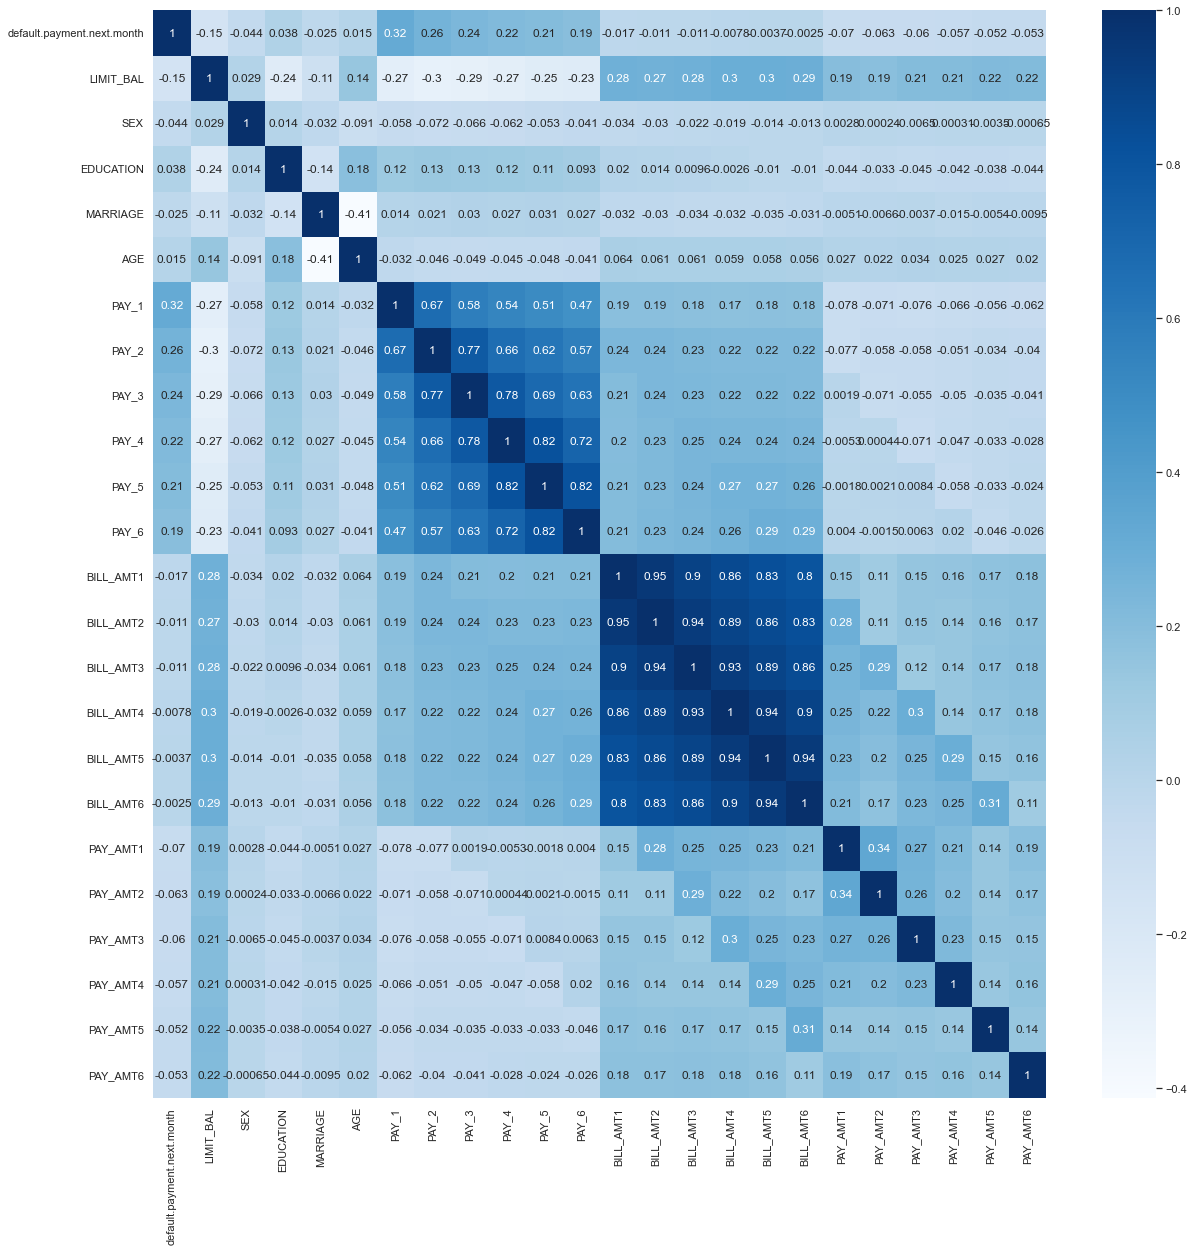

In [7]:
cor = pd.concat((y_train, X_train.drop(columns=['ID'])), axis=1).corr()
plt.figure(figsize=(20, 20))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues);


We plot the correlations between various features. We can see repayment status features PAY_* have the highest correlation with with default.payment.next.month.

In [8]:
pays = pd.concat((X_train.loc[:, 'PAY_1':'PAY_6'], y_train), axis=1)
alt.data_transformers.disable_max_rows()
alt.Chart(pays).mark_square().encode(
    x=alt.X('default\.payment\.next\.month:O', title='default.payment.next.month'),
    y=alt.Y(alt.repeat(), type='ordinal'),
    color='count()',
    size='count()'
).repeat(['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])

alt.RepeatChart(...)

We can see the distribution of target classes for each repayment status feature. We can observe an increase of defaulted class as the repayment status value increases.

# Preprocessing

In [9]:
numeric_features = ['LIMIT_BAL', 'AGE',
                    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
                    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
categorical_features = ['MARRIAGE']
binary_features = ['SEX']
drop_features = ['ID']
passthrough_features = ['EDUCATION', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown='ignore'), categorical_features),
    (OneHotEncoder(drop='if_binary', dtype=int), binary_features),
    ('drop', drop_features),
    ('passthrough', passthrough_features)
)

# Baseline

The following function used for displaying scores is taken from lecture notes of DSCI 571 at UBC.

In [10]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [11]:
results_dict = {}
scoring_metrics = ['accuracy', 'precision', 'recall', 'f1']
dummy = DummyClassifier()
pipe = make_pipeline(preprocessor, dummy)
results_dict["Dummy"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results_dict)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zer

,Dummy
fit_time,0.028 (+/- 0.003)
score_time,0.017 (+/- 0.004)
test_accuracy,0.778 (+/- 0.000)
train_accuracy,0.778 (+/- 0.000)
test_precision,0.000 (+/- 0.000)
train_precision,0.000 (+/- 0.000)
test_recall,0.000 (+/- 0.000)
train_recall,0.000 (+/- 0.000)
test_f1,0.000 (+/- 0.000)
train_f1,0.000 (+/- 0.000)


# Linear models

In [12]:
gs_pipe = make_pipeline(preprocessor, LogisticRegression(max_iter=200))
param_grid = {"logisticregression__C": 10.0 ** np.arange(-3, 4)}
grid_search = GridSearchCV(
    gs_pipe, param_grid, n_jobs=-1, return_train_score=True, scoring='f1'
)
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('standardscaler',
                                                                         StandardScaler(),
                                                                         ['LIMIT_BAL',
                                                                          'AGE',
                                                                          'BILL_AMT1',
                                                                          'BILL_AMT2',
                                                                          'BILL_AMT3',
                                                                          'BILL_AMT4',
                                                                          'BILL_AMT5',
                                                                          'BILL_AMT6',
                                                                   

In [13]:
mean_train_scores = grid_search.cv_results_['mean_train_score']
mean_test_scores = grid_search.cv_results_['mean_test_score']
std_train_scores = grid_search.cv_results_['std_train_score']
std_test_scores = grid_search.cv_results_['std_test_score']
c_values = grid_search.param_grid['logisticregression__C'].tolist()
gs_dict = {}
for (mean_train_score,
     mean_test_score,
     std_train_score,
     std_test_score, 
     c_value) in zip(mean_train_scores,
                     mean_test_scores,
                     std_train_scores,
                     std_test_scores,
                     c_values):
    gs_dict[f'C={c_value}'] = dict(mean_train_f1=f"%0.3f (+/- %0.3f)" % (mean_train_score, std_train_score),
                                   mean_test_f1=f"%0.3f (+/- %0.3f)" % (mean_test_score, std_test_score))
pd.DataFrame(gs_dict)

,C=0.001,C=0.01,C=0.1,C=1.0,C=10.0,C=100.0,C=1000.0
mean_train_f1,0.278 (+/- 0.009),0.345 (+/- 0.010),0.354 (+/- 0.010),0.356 (+/- 0.010),0.356 (+/- 0.010),0.356 (+/- 0.010),0.356 (+/- 0.010)
mean_test_f1,0.278 (+/- 0.020),0.342 (+/- 0.022),0.352 (+/- 0.022),0.354 (+/- 0.022),0.354 (+/- 0.022),0.354 (+/- 0.022),0.354 (+/- 0.022)


Best estimator results compared with baseline:

In [14]:
results_dict["LogisticRegression"] = mean_std_cross_val_scores(
    grid_search.best_estimator_, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)
pd.DataFrame(results_dict)

,Dummy,LogisticRegression
fit_time,0.028 (+/- 0.003),0.275 (+/- 0.025)
score_time,0.017 (+/- 0.004),0.029 (+/- 0.016)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001)
test_precision,0.000 (+/- 0.000),0.720 (+/- 0.032)
train_precision,0.000 (+/- 0.000),0.719 (+/- 0.005)
test_recall,0.000 (+/- 0.000),0.234 (+/- 0.019)
train_recall,0.000 (+/- 0.000),0.236 (+/- 0.009)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011)


In [15]:
grid_search.best_params_

{'logisticregression__C': 1.0}

The linear regression model is not very sensitive to hyperparameter C. The validation f1 score changed little for C greater or equal to 1. The best estimator has $C=1.0$, which is the default value. The linear regression model has better validation accuracy than the baseline.

# Other models

**DecisionTreeClassifier**

In [16]:
pipe = make_pipeline(preprocessor, DecisionTreeClassifier())
results_dict["DecisionTreeClassifier"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

**RandomForestClassifier**

In [17]:
pipe = make_pipeline(preprocessor, RandomForestClassifier())
results_dict["RandomForestClassifier"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

**SVC with RBF Kernel**

In [18]:
pipe = make_pipeline(preprocessor, SVC(random_state=123))
results_dict["SVC"] = mean_std_cross_val_scores(
    pipe, X_train, y_train, return_train_score=True, scoring=scoring_metrics
)

**Results**

In [19]:
pd.DataFrame(results_dict)

,Dummy,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,SVC
fit_time,0.028 (+/- 0.003),0.275 (+/- 0.025),0.392 (+/- 0.012),4.962 (+/- 0.172),15.567 (+/- 0.373)
score_time,0.017 (+/- 0.004),0.029 (+/- 0.016),0.014 (+/- 0.001),0.110 (+/- 0.007),4.206 (+/- 0.275)
test_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.005),0.722 (+/- 0.003),0.816 (+/- 0.006),0.819 (+/- 0.005)
train_accuracy,0.778 (+/- 0.000),0.810 (+/- 0.001),0.999 (+/- 0.000),0.999 (+/- 0.000),0.824 (+/- 0.001)
test_precision,0.000 (+/- 0.000),0.720 (+/- 0.032),0.382 (+/- 0.008),0.649 (+/- 0.023),0.687 (+/- 0.019)
train_precision,0.000 (+/- 0.000),0.719 (+/- 0.005),1.000 (+/- 0.000),0.999 (+/- 0.000),0.708 (+/- 0.005)
test_recall,0.000 (+/- 0.000),0.234 (+/- 0.019),0.405 (+/- 0.017),0.370 (+/- 0.020),0.339 (+/- 0.014)
train_recall,0.000 (+/- 0.000),0.236 (+/- 0.009),0.997 (+/- 0.001),0.998 (+/- 0.000),0.355 (+/- 0.005)
test_f1,0.000 (+/- 0.000),0.354 (+/- 0.024),0.393 (+/- 0.012),0.472 (+/- 0.020),0.454 (+/- 0.016)
train_f1,0.000 (+/- 0.000),0.356 (+/- 0.011),0.999 (+/- 0.000),0.999 (+/- 0.000),0.473 (+/- 0.005)


Out of all nonlinear models, SVC with rbf kernel has the highest fit and score time and DecisionTreeClassifier has the lowest. RandomForestClassifier and DecisionTreeClassifier both overfitted the train data as the train scores are close to 1 much higher than the respective validation scores. SVC did not overfit the train data as the train and validation scores are close for all metrics. RandomForestClassifier has the best validation f1 score.

# Hyperparameter optimization

In [20]:
optimized_dict = {}


def optimize_model(model_name, model, param_grid):
    pipe = make_pipeline(preprocessor, model)
    random_search = RandomizedSearchCV(
        pipe,
        param_grid,
        n_iter=30,
        verbose=0,
        n_jobs=-1,
        random_state=123,
        return_train_score=True,
        scoring='f1'
    )
    random_search.fit(X_train, y_train)
    param_list = []
    for k, v in random_search.best_params_.items():
        if type(v) == float:
            v = round(v, 3)
        name = k.split('__')[-1]
        param_list.append(f'{name}: {v}')
    optimized_dict[model_name] = mean_std_cross_val_scores(
        random_search.best_estimator_, X_train, y_train, return_train_score=True, scoring=scoring_metrics
    )
    optimized_dict[model_name]['best_params'] = ' '.join(param_list)
    return random_search.best_estimator_

**DecisionTreeClassifier**

In [21]:
model_name = 'DecisionTreeClassifier'
model = DecisionTreeClassifier()
param_grid = {'decisiontreeclassifier__class_weight': ['balanced', None],
              'decisiontreeclassifier__max_depth': randint(3, 30)}
tuned_dtc = optimize_model(model_name, model, param_grid)

**RandomForestClassifier**

In [22]:
model_name = 'RandomForestClassifier'
model = RandomForestClassifier(random_state=123)
param_grid = {'randomforestclassifier__class_weight': ['balanced', None],
              'randomforestclassifier__max_depth': randint(3, 30)}
tuned_rfc = optimize_model(model_name, model, param_grid)

**SVC**

In [23]:
model_name = 'SVC'
model = SVC(random_state=123)
param_grid = {
    'svc__C': loguniform(1e-3, 1e3),
    'svc__gamma': loguniform(1e-3, 1e3),
    'svc__class_weight': ['balanced', None]
}
tuned_svc = optimize_model(model_name, model, param_grid)

**Hyperparameter Tuning Results**

In [24]:
pd.DataFrame(optimized_dict)

,DecisionTreeClassifier,RandomForestClassifier,SVC
fit_time,0.101 (+/- 0.005),1.612 (+/- 0.021),22.359 (+/- 0.245)
score_time,0.014 (+/- 0.004),0.048 (+/- 0.000),5.548 (+/- 0.039)
test_accuracy,0.767 (+/- 0.009),0.779 (+/- 0.009),0.766 (+/- 0.006)
train_accuracy,0.771 (+/- 0.004),0.785 (+/- 0.004),0.813 (+/- 0.004)
test_precision,0.480 (+/- 0.017),0.502 (+/- 0.018),0.477 (+/- 0.011)
train_precision,0.488 (+/- 0.007),0.513 (+/- 0.008),0.565 (+/- 0.008)
test_recall,0.575 (+/- 0.019),0.590 (+/- 0.020),0.575 (+/- 0.019)
train_recall,0.584 (+/- 0.007),0.603 (+/- 0.002),0.689 (+/- 0.006)
test_f1,0.523 (+/- 0.017),0.543 (+/- 0.019),0.522 (+/- 0.014)
train_f1,0.532 (+/- 0.004),0.554 (+/- 0.005),0.621 (+/- 0.003)


In [25]:
preprocessor.fit(X_train)
feature_names = numeric_features + preprocessor.named_transformers_['onehotencoder-1'].get_feature_names_out().tolist() +\
                preprocessor.named_transformers_['onehotencoder-2'].get_feature_names_out().tolist() +\
                passthrough_features
X_train_enc = pd.DataFrame(
    data=preprocessor.transform(X_train),
    columns=feature_names,
    index=X_train.index,
)

In [26]:
rfc_explainer = shap.TreeExplainer(tuned_rfc.named_steps["randomforestclassifier"])
train_rfc_shap_values = rfc_explainer.shap_values(X_train_enc)

In [27]:
pd.DataFrame(data=np.abs(train_rfc_shap_values[1]).mean(0),
    index=feature_names, columns=["SHAP"]).sort_values(
    by="SHAP", ascending=False
)[:10]

,SHAP
PAY_1,0.074936
PAY_2,0.042399
PAY_3,0.018892
LIMIT_BAL,0.017943
PAY_AMT2,0.015647
PAY_4,0.015037
PAY_5,0.013215
PAY_AMT3,0.012552
PAY_6,0.012249
PAY_AMT1,0.011753


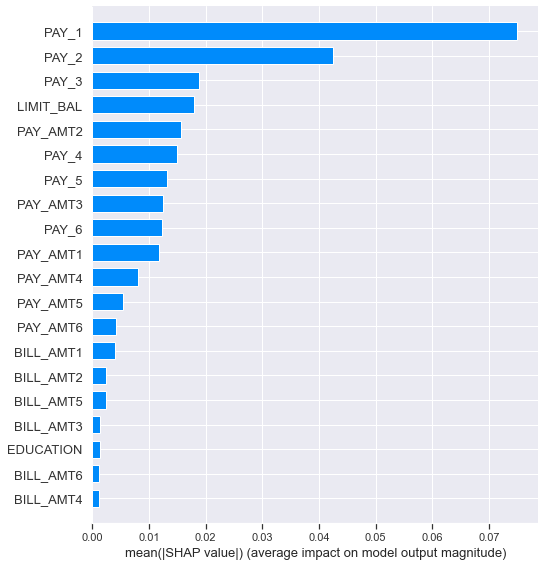

In [28]:
shap.summary_plot(train_rfc_shap_values[1], X_train_enc, plot_type="bar")

From the shap feature important chart and plot, we can see that the most important features globally are repayment status features `PAY_*`, and payment amounts `PAY_AMT*` with records from more recent months being more important. `LIMIT_BAL` amount of given credit ranks also high in feature importance.

# Results on the test set

In [29]:
predictions = tuned_rfc.predict(X_test)
print("Test f1 score: ", f1_score(y_test, predictions))

Test f1 score:  0.532829150910966


The test score is very close to the validation score of the tuned random forest classifier. Because the train, validation, and test f1 scores are close, we can trust the test results and conclude there isn't significant optimization bias.

In [30]:
X_test_enc = pd.DataFrame(
    data=preprocessor.transform(X_test),
    columns=feature_names,
    index=X_test.index,
)
rfc_explainer = shap.TreeExplainer(tuned_rfc.named_steps["randomforestclassifier"])
test_rfc_shap_values = rfc_explainer.shap_values(X_test_enc)
X_test_enc = round(X_test_enc, 3)

In [31]:
print('predictions: ', predictions)

predictions:  [0 0 1 ... 1 0 0]


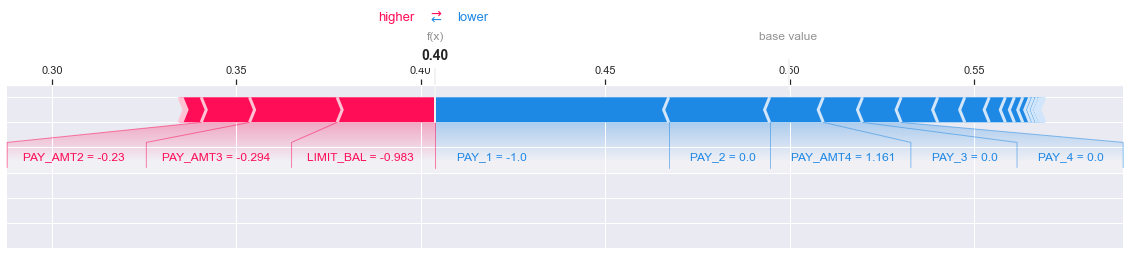

In [32]:
shap.force_plot(
    rfc_explainer.expected_value[1],
    test_rfc_shap_values[1][0, :],
    X_test_enc.iloc[0, :],
    matplotlib=True,
)

The raw model score is lower than the base value, as expected from the observation belonging to the not defaulted (0) class. Scaled `PAY_AMT2`=-0.23, `PAY_AMT3`=-0.294, `LIMIT_BAL`=-0.983 are busing the prediction towards higher score; `PAY_1`=-1.0, `PAY_2`=0.0, scaled `PAY_AMT4`=1.161, `PAY_3`=0.0, `PAY_AMT4`=0.0 are pushing the prediction towards lower score.

# Summary

| Item | Results |
| --- | ----------- |
| Task | Predict whether credit card client will default |
| Type | Classification |
| Best Model | RandomForestClassifier |
| Hyperparameters| class_weight: balanced max_depth: 5 |
| Test F1 score | 0.532 |
| Most important features | Previous repayment delay, amount of previous payment, credit limit |

**Concluding remarks**

In this project, we examined the performance of different classfiers on the credit card client default payment task. The RandomForestClassifer class with class_weight set to "balanced" and max_depth to 5 shows the best f1 score on the validation and test set. The final test score is 0.532. The task consistently shows that Previous repayment delay, amount of previous payment, credit limit are the most important features to predict whether a credit card client will default or now.

**Potential Improvement**

Due to time and computer performance constraints, we skipped feature selection which has the potential to further improve the test scores. Also, previous repayment delay and amount of previous payment are separated into 6 different months. But the 6 separate features for each group could potentially be combined into 1 sum or mean value feature without losing performance while improving interpretability and reducing model size.